# Just Numpy

Let's start with a plausible problem. We have a dataset of all daily temperatures measured at Newark since 1893 and we want to analyze it. First, let's try that with a Python list.

In [1]:
temperatures = []
with open("data/newark-temperature-avg.txt") as file:
    for line in file.readlines():
        temperatures.append(float(line))

len(temperatures), temperatures[:10], temperatures[-10:]

(42019,
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 [43.0, 47.0, 49.0, 52.0, 48.0, 52.0, 62.0, 68.0, 59.0, 47.0])

Much of the record is missing, as we can see by counting NaNs:

In [2]:
import math
numbad = 0
for x in temperatures:
    if math.isnan(x):
        numbad += 1

numbad / len(temperatures)

0.887717461148528

We have a more complete dataset of daily minimum and maximum temperatures. It's not as accurate, but we can impute the missing averages by averaging the minimum and maximum.

In [4]:
min_temperatures = []
with open("data/newark-temperature-min.txt") as file:
    for line in file.readlines():
        min_temperatures.append(float(line))

max_temperatures = []
with open("data/newark-temperature-max.txt") as file:
    for line in file.readlines():
        max_temperatures.append(float(line))

(len(min_temperatures), min_temperatures[:10], min_temperatures[-10:],
 len(max_temperatures), max_temperatures[:10], max_temperatures[-10:])

(42019,
 [26.0, 34.0, 17.0, 13.0, 17.0, 13.0, 12.0, 15.0, 11.0, 4.0],
 [36.0, 45.0, 45.0, 44.0, 39.0, 37.0, 52.0, 65.0, 46.0, nan],
 42019,
 [52.0, 43.0, 32.0, 23.0, 27.0, 30.0, 28.0, 28.0, 32.0, 32.0],
 [50.0, 50.0, 54.0, 59.0, 58.0, 68.0, 73.0, 73.0, 67.0, nan])

While we fill in the missing values, let's also measure how long it takes.

In [5]:
%%timeit

imputed_temperatures = []
for average, minimum, maximum in zip(temperatures, min_temperatures, max_temperatures):
    if math.isnan(average):
        imputed_temperatures.append(0.5 * (minimum + maximum))
    else:
        imputed_temperatures.append(average)

21.5 ms ± 64.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now let's do the same thing in Numpy, again measuring the time.

In [6]:
import numpy

temperatures = numpy.array(temperatures)
min_temperatures = numpy.array(min_temperatures)
max_temperatures = numpy.array(max_temperatures)

In [8]:
%%timeit

missing = numpy.isnan(temperatures)
imputed_temperatures = numpy.empty(len(temperatures), dtype=numpy.float64)
imputed_temperatures[missing] = 0.5 * (min_temperatures[missing] + max_temperatures[missing])
imputed_temperatures[~missing] = temperatures[~missing]

189 µs ± 1.06 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Or just

In [9]:
%%timeit

imputed_temperatures = numpy.where(
    # condition                # if true                                    # if false
    numpy.isnan(temperatures), 0.5 * (min_temperatures + max_temperatures), temperatures)

76.1 µs ± 1.05 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


We see that Numpy can be much faster than Python loops, in this case a factor of 10 or 20, but I have seen as much as 1000. (It depends on the application.) The way you tell it what to do is also very different, which may be good or bad. It may read more naturally, maybe not.

One thing we saw was a preoccupation on data types, unusual for Python.

In [10]:
numpy.zeros(5, dtype=numpy.float64)

array([0., 0., 0., 0., 0.])

In [11]:
numpy.zeros(5, dtype=numpy.int32)

array([0, 0, 0, 0, 0], dtype=int32)

In [12]:
numpy.zeros(5, dtype=numpy.bool)

array([False, False, False, False, False])

In [13]:
numpy.zeros(5, dtype="S3")

array([b'', b'', b'', b'', b''], dtype='|S3')

This is where a large part of Numpy's speed comes from. When Python churns, a lot of that time is spent checking and re-checking data types, which in a compiled language like C++ were checked once and for all in the compilation step.

Numpy is a suite of compiled functions applied to data with predetermined types. When you're using Numpy properly, you'll have very few `for` loops and `if` statements in your code: the Python code acts as a high-level director, while Numpy does its looping in compiled code.

The Numpy library consists mainly of one class, `numpy.ndarray`, and operations on it. This is an n-dimensional array of contiguous data. Some operations change that data or make new arrays, but many operations merely change our interpretation of the data. The latter are the fastest.

In [14]:
array = numpy.arange(24, dtype=numpy.float64)    # 64-bit floating point numbers
array

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

In [15]:
array.view(numpy.int64)

array([                  0, 4607182418800017408, 4611686018427387904,
       4613937818241073152, 4616189618054758400, 4617315517961601024,
       4618441417868443648, 4619567317775286272, 4620693217682128896,
       4621256167635550208, 4621819117588971520, 4622382067542392832,
       4622945017495814144, 4623507967449235456, 4624070917402656768,
       4624633867356078080, 4625196817309499392, 4625478292286210048,
       4625759767262920704, 4626041242239631360, 4626322717216342016,
       4626604192193052672, 4626885667169763328, 4627167142146473984])

In [16]:
array.view("S8")

array([b'', b'\x00\x00\x00\x00\x00\x00\xf0?',
       b'\x00\x00\x00\x00\x00\x00\x00@', b'\x00\x00\x00\x00\x00\x00\x08@',
       b'\x00\x00\x00\x00\x00\x00\x10@', b'\x00\x00\x00\x00\x00\x00\x14@',
       b'\x00\x00\x00\x00\x00\x00\x18@', b'\x00\x00\x00\x00\x00\x00\x1c@',
       b'\x00\x00\x00\x00\x00\x00 @', b'\x00\x00\x00\x00\x00\x00"@',
       b'\x00\x00\x00\x00\x00\x00$@', b'\x00\x00\x00\x00\x00\x00&@',
       b'\x00\x00\x00\x00\x00\x00(@', b'\x00\x00\x00\x00\x00\x00*@',
       b'\x00\x00\x00\x00\x00\x00,@', b'\x00\x00\x00\x00\x00\x00.@',
       b'\x00\x00\x00\x00\x00\x000@', b'\x00\x00\x00\x00\x00\x001@',
       b'\x00\x00\x00\x00\x00\x002@', b'\x00\x00\x00\x00\x00\x003@',
       b'\x00\x00\x00\x00\x00\x004@', b'\x00\x00\x00\x00\x00\x005@',
       b'\x00\x00\x00\x00\x00\x006@', b'\x00\x00\x00\x00\x00\x007@'],
      dtype='|S8')

In [17]:
array.tostring()

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\x00@\x00\x00\x00\x00\x00\x00\x08@\x00\x00\x00\x00\x00\x00\x10@\x00\x00\x00\x00\x00\x00\x14@\x00\x00\x00\x00\x00\x00\x18@\x00\x00\x00\x00\x00\x00\x1c@\x00\x00\x00\x00\x00\x00 @\x00\x00\x00\x00\x00\x00"@\x00\x00\x00\x00\x00\x00$@\x00\x00\x00\x00\x00\x00&@\x00\x00\x00\x00\x00\x00(@\x00\x00\x00\x00\x00\x00*@\x00\x00\x00\x00\x00\x00,@\x00\x00\x00\x00\x00\x00.@\x00\x00\x00\x00\x00\x000@\x00\x00\x00\x00\x00\x001@\x00\x00\x00\x00\x00\x002@\x00\x00\x00\x00\x00\x003@\x00\x00\x00\x00\x00\x004@\x00\x00\x00\x00\x00\x005@\x00\x00\x00\x00\x00\x006@\x00\x00\x00\x00\x00\x007@'

In [18]:
numpy.array([b"one", b"two", b"three"]).view(numpy.uint8)

array([111, 110, 101,   0,   0, 116, 119, 111,   0,   0, 116, 104, 114,
       101, 101], dtype=uint8)

In [19]:
list(b"one\x00\x00two\x00\x00three")

[111, 110, 101, 0, 0, 116, 119, 111, 0, 0, 116, 104, 114, 101, 101]

In [20]:
array.reshape(6, 4)

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.],
       [12., 13., 14., 15.],
       [16., 17., 18., 19.],
       [20., 21., 22., 23.]])

In [21]:
array.reshape(6, 4, order="f")    # Fortran order vs C order: how a 1D sequence covers an nD block

array([[ 0.,  6., 12., 18.],
       [ 1.,  7., 13., 19.],
       [ 2.,  8., 14., 20.],
       [ 3.,  9., 15., 21.],
       [ 4., 10., 16., 22.],
       [ 5., 11., 17., 23.]])

This interpretation has only two parameters:

   * `dtype` (data type, including endianness): how bytes are represented as numbers
   * `shape` and `order`: how those numbers are arranged in an n-dimensional grid

Mistakes in interpretation are usually not subtle, so just be sure to _look_ at your data.

Numpy arrays can be used in mathematical formulae, but instead of computing one value, they compute a whole array of values, element by element.

In [22]:
a = numpy.arange(10)
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [23]:
a + 100

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109])

In [24]:
b = numpy.array([0.0, 1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9])

In [25]:
a + b

array([ 0. ,  2.1,  4.2,  6.3,  8.4, 10.5, 12.6, 14.7, 16.8, 18.9])

In [26]:
a**2

array([ 0,  1,  4,  9, 16, 25, 36, 49, 64, 81])

Generally, you can imagine a table of data to compute: the columns represent meaningful quantities (often named) while the rows represent anonymous instances.

In [27]:
a = numpy.random.uniform(5, 10, 10000)
b = numpy.random.uniform(10, 20, 10000)
c = numpy.random.uniform(-0.1, 0.1, 10000)
len(a)

10000

A conventional Python approach would be to compute the formula on each instance, one after another.

In [28]:
roots1 = []
for ai, bi, ci in zip(a, b, c):
    roots1.append((-bi + math.sqrt(bi**2 - 4*ai*ci)) / (2*ai))

The Numpy approach computes each step of the formula on all instances before moving on to the next step.

In [29]:
roots2 = (-b + numpy.sqrt(b**2 - 4*a*c)) / (2*a)

The Numpy expression (`(-b + numpy.sqrt(b**2 - 4*a*c)) / (2*a)`) is equivalent to:

In [30]:
tmp1 = numpy.negative(b)            # -b
tmp2 = numpy.square(b)              # b**2
tmp3 = numpy.multiply(4, a)         # 4*a
tmp4 = numpy.multiply(tmp3, c)      # tmp3*c
tmp5 = numpy.subtract(tmp2, tmp4)   # tmp2 - tmp4
tmp6 = numpy.sqrt(tmp5)             # sqrt(tmp5)
tmp7 = numpy.add(tmp1, tmp6)        # tmp1 + tmp6
tmp8 = numpy.multiply(2, a)         # 2*a
roots3 = numpy.divide(tmp7, tmp8)   # tmp7 / tmp8

One strange (but useful!) consequence of this rule that mathematical operations are applied elementwise is that it even applies to comparisons. Suppose we want to verify that the `roots1` computed in the Python loop match the `roots2` and `roots3` computed by Numpy.

In [31]:
roots1 == roots2

array([ True,  True,  True, ...,  True,  True,  True])

In [32]:
roots2 == roots3

array([ True,  True,  True, ...,  True,  True,  True])

When you want to check that _all_ of the elements are equal, I'd use `.all()`.

In [33]:
(roots2 == roots3).all()

True

In [34]:
(roots1 == roots2).all()

False

Why is that? Didn't we just see that `roots1 == roots2` is `True, True, True, ...`?

In [35]:
(roots1 == roots2).any()

True

In [36]:
(roots1 == roots2).sum(), len(roots1)

(9875, 10000)

Which ones fail?

In [37]:
numpy.nonzero(roots1 != roots2)

(array([ 176,  198,  207,  210,  237,  346,  419,  465,  569,  618,  623,
         625,  626,  889,  975, 1168, 1202, 1208, 1300, 1384, 1475, 1479,
        1516, 1676, 1782, 1926, 1985, 1998, 2074, 2076, 2084, 2155, 2187,
        2234, 2248, 2319, 2406, 2618, 2667, 2716, 2759, 3071, 3196, 3206,
        3527, 3718, 3730, 3874, 4033, 4038, 4114, 4164, 4387, 4393, 4499,
        4572, 4588, 4988, 4997, 5186, 5194, 5200, 5219, 5297, 5309, 5344,
        5400, 5404, 5591, 5874, 5887, 5891, 5899, 6008, 6078, 6096, 6106,
        6135, 6223, 6283, 6286, 6294, 6325, 6359, 6367, 6436, 6506, 6616,
        6678, 6944, 7646, 7743, 7920, 8036, 8098, 8120, 8204, 8294, 8306,
        8401, 8495, 8552, 8555, 8623, 8648, 8724, 8823, 8838, 8886, 8940,
        8941, 8942, 9065, 9239, 9282, 9309, 9329, 9434, 9495, 9532, 9563,
        9628, 9677, 9846, 9951]),)

In [40]:
roots1[176], roots2[176]

(0.0003841519056395488, 0.0003841519056398594)

In [41]:
roots1[176] - roots2[176]

-3.1056971230847275e-16

Numpy uses different routines to do its calculations, so results might not be exactly the same. We don't care about last-digit differences, so we set a tolerance.

In [42]:
(abs(roots1 - roots2) < 1e-15).all()

True

The upshot of this is that you can perform a calculation with the same expression on Numpy arrays as on Python scalars, as long as it's being applied to a table of numbers (i.e. arrays of all the same length).

Now let's get into some fancier gymnastics.

Python has a wonderfully consistent syntax for _slicing_ lists (or tuples or whatever):

In [51]:
alist = [0.0, 1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9]
alist[4]

4.4

In [52]:
alist[4:]

[4.4, 5.5, 6.6, 7.7, 8.8, 9.9]

In [53]:
alist[:7]

[0.0, 1.1, 2.2, 3.3, 4.4, 5.5, 6.6]

In [54]:
alist[-1]

9.9

In [55]:
alist[:-3]

[0.0, 1.1, 2.2, 3.3, 4.4, 5.5, 6.6]

In [56]:
alist[3:8]

[3.3, 4.4, 5.5, 6.6, 7.7]

The third argument of a slice is the _stride,_ the amount to skip between elements.

In [57]:
alist = [0.0, 1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9]
alist[3:8:2]

[3.3, 5.5, 7.7]

In [58]:
alist[::2]

[0.0, 2.2, 4.4, 6.6, 8.8]

In [59]:
alist[::-2]

[9.9, 7.7, 5.5, 3.3, 1.1]

In [60]:
alist[5::-1]

[5.5, 4.4, 3.3, 2.2, 1.1, 0.0]

Numpy arrays share this syntax— everything that works for a list works for an array— but they extend it considerably.

In [61]:
array = numpy.array([[0.0, 1.1, 2.2, 3.3], [0, 10.1, 20.2, 30.3], [0, 100.1, 200.2, 300.3]])
array

array([[  0. ,   1.1,   2.2,   3.3],
       [  0. ,  10.1,  20.2,  30.3],
       [  0. , 100.1, 200.2, 300.3]])

In [62]:
array[1]

array([ 0. , 10.1, 20.2, 30.3])

In [63]:
array[:, 1]

array([  1.1,  10.1, 100.1])

In [64]:
array[1:, 2:]

array([[ 20.2,  30.3],
       [200.2, 300.3]])

In [65]:
array[::2, 1::2]

array([[  1.1,   3.3],
       [100.1, 300.3]])

Even arrays (or sequences) of booleans or integers can be slices.

In [69]:
array = numpy.array([[0.0, 1.1, 2.2, 3.3], [0, 10.1, 20.2, 30.3], [0, 100.1, 200.2, 300.3]])
array[[False, True, True]]

array([[  0. ,  10.1,  20.2,  30.3],
       [  0. , 100.1, 200.2, 300.3]])

In [67]:
array[[2, 1, 0]]

array([[  0. , 100.1, 200.2, 300.3],
       [  0. ,  10.1,  20.2,  30.3],
       [  0. ,   1.1,   2.2,   3.3]])

In [68]:
array[[2, 1, 1, 1, 1, 0, 0, 2]]

array([[  0. , 100.1, 200.2, 300.3],
       [  0. ,  10.1,  20.2,  30.3],
       [  0. ,  10.1,  20.2,  30.3],
       [  0. ,  10.1,  20.2,  30.3],
       [  0. ,  10.1,  20.2,  30.3],
       [  0. ,   1.1,   2.2,   3.3],
       [  0. ,   1.1,   2.2,   3.3],
       [  0. , 100.1, 200.2, 300.3]])

What could this possibly be useful for?

**Masking:**

In [70]:
a = numpy.array([0.0, 1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9])
b = numpy.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900])

In [71]:
b > 400

array([False, False, False, False, False,  True,  True,  True,  True,
        True])

In [72]:
a[b > 400]

array([5.5, 6.6, 7.7, 8.8, 9.9])

**Sorting and maximizing:**

In [73]:
a = numpy.random.normal(0, 5, 50)
b = abs(a)

In [74]:
numpy.argsort(a)

array([29,  3, 11, 21, 12, 17, 35,  6, 37, 15,  8,  5, 34,  9, 20, 28, 31,
       40, 42, 18, 10, 41, 45,  1, 26, 49, 19, 43, 38, 14, 33, 32, 16, 25,
       24,  4, 46, 30,  0, 27,  2, 23, 13, 36, 47,  7, 48, 39, 22, 44])

In [75]:
a[numpy.argsort(a)]

array([-12.4733492 ,  -9.92878045,  -9.64554881,  -8.81629801,
        -8.34266724,  -6.09744858,  -5.03665044,  -4.88530747,
        -4.84937532,  -4.2670565 ,  -3.33331748,  -3.23658218,
        -2.63572111,  -2.63008637,  -2.49689815,  -2.38672626,
        -2.13490273,  -2.09316631,  -1.98461848,  -1.76594742,
        -1.73260592,  -1.61617525,  -1.55285382,  -1.41242675,
        -1.32889058,  -1.04434419,  -0.90247921,  -0.15975729,
         0.21724299,   0.44759251,   1.01515799,   1.16607299,
         1.90236805,   2.08971993,   2.2443114 ,   2.28442914,
         2.47199009,   2.74969602,   3.38810464,   3.42591887,
         3.80069311,   3.99202026,   4.61029226,   4.7751338 ,
         5.94184301,   6.31256481,   6.65368588,   7.17218679,
         7.38735131,  10.35889608])

In [76]:
a = numpy.meshgrid(numpy.linspace(-5, 5, 11), numpy.linspace(-5, 5, 11))[1]
a

array([[-5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.],
       [-4., -4., -4., -4., -4., -4., -4., -4., -4., -4., -4.],
       [-3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.],
       [-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.],
       [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.],
       [ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.]])

In [77]:
a.argmax(axis=0)

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [78]:
a[a.argmax(axis=0)]

array([[5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]])

**Dictionary encoding:**

In [79]:
text = """Four score and seven years ago our fathers brought forth on this
continent, a new nation, conceived in Liberty, and dedicated to the proposition
that all men are created equal.

Now we are engaged in a great civil war, testing whether that nation, or any
nation so conceived and so dedicated, can long endure. We are met on a great
battle-field of that war. We have come to dedicate a portion of that field, as
a final resting place for those who here gave their lives that that nation might
live. It is altogether fitting and proper that we should do this.

But, in a larger sense, we can not dedicate -- we can not consecrate -- we can
not hallow -- this ground. The brave men, living and dead, who struggled here,
have consecrated it, far above our poor power to add or detract. The world will
little note, nor long remember what we say here, but it can never forget what
they did here. It is for us the living, rather, to be dedicated here to the
unfinished work which they who fought here have thus far so nobly advanced. It
is rather for us to be here dedicated to the great task remaining before us --
that from these honored dead we take increased devotion to that cause for which
they gave the last full measure of devotion -- that we here highly resolve that
these dead shall not have died in vain -- that this nation, under God, shall
have a new birth of freedom -- and that government of the people, by the people,
for the people, shall not perish from the earth."""

In [80]:
words = text.replace(".", "").replace(",", "").replace("--", "").split()

In [81]:
dictionary, integers = numpy.unique(words, return_inverse=True)

In [82]:
len(words), len(dictionary)

(271, 142)

In [83]:
dictionary

array(['But', 'Four', 'God', 'It', 'Liberty', 'Now', 'The', 'We', 'a',
       'above', 'add', 'advanced', 'ago', 'all', 'altogether', 'and',
       'any', 'are', 'as', 'battle-field', 'be', 'before', 'birth',
       'brave', 'brought', 'but', 'by', 'can', 'cause', 'civil', 'come',
       'conceived', 'consecrate', 'consecrated', 'continent', 'created',
       'dead', 'dedicate', 'dedicated', 'detract', 'devotion', 'did',
       'died', 'do', 'earth', 'endure', 'engaged', 'equal', 'far',
       'fathers', 'field', 'final', 'fitting', 'for', 'forget', 'forth',
       'fought', 'freedom', 'from', 'full', 'gave', 'government', 'great',
       'ground', 'hallow', 'have', 'here', 'highly', 'honored', 'in',
       'increased', 'is', 'it', 'larger', 'last', 'little', 'live',
       'lives', 'living', 'long', 'measure', 'men', 'met', 'might',
       'nation', 'never', 'new', 'nobly', 'nor', 'not', 'note', 'of',
       'on', 'or', 'our', 'people', 'perish', 'place', 'poor', 'portion',
       'po

In [84]:
integers

array([  1, 109,  15, 111, 141,  12,  94,  49,  24,  55,  92, 124,  34,
         8,  86,  84,  31,  69,   4,  15,  38, 127, 120, 102, 119,  13,
        81,  17,  35,  47,   5, 133,  17,  46,  69,   8,  62,  29, 132,
       118, 135, 119,  84,  93,  16,  84, 114,  31,  15, 114,  38,  27,
        79,  45,   7,  17,  82,  92,   8,  62,  19,  91, 119, 132,   7,
        65,  30, 127,  37,   8,  99,  91, 119,  50,  18,   8,  51, 107,
        97,  53, 125, 137,  66,  60, 121,  77, 119, 119,  84,  83,  76,
         3,  71,  14,  52,  15, 101, 119, 133, 113,  43, 124,   0,  69,
         8,  73, 110, 133,  27,  89,  37, 133,  27,  89,  32, 133,  27,
        89,  64, 124,  63,   6,  23,  81,  78,  15,  36, 137, 115,  66,
        65,  33,  72,  48,   9,  94,  98, 100, 127,  10,  93,  39,   6,
       140, 138,  75,  90,  88,  79, 105, 134, 133, 108,  66,  25,  72,
        27,  85,  54, 134, 123,  41,  66,   3,  71,  53, 130, 120,  78,
       103, 127,  20,  38,  66, 127, 120, 129, 139, 136, 123, 13

In [85]:
dictionary[integers]

array(['Four', 'score', 'and', 'seven', 'years', 'ago', 'our', 'fathers',
       'brought', 'forth', 'on', 'this', 'continent', 'a', 'new',
       'nation', 'conceived', 'in', 'Liberty', 'and', 'dedicated', 'to',
       'the', 'proposition', 'that', 'all', 'men', 'are', 'created',
       'equal', 'Now', 'we', 'are', 'engaged', 'in', 'a', 'great',
       'civil', 'war', 'testing', 'whether', 'that', 'nation', 'or',
       'any', 'nation', 'so', 'conceived', 'and', 'so', 'dedicated',
       'can', 'long', 'endure', 'We', 'are', 'met', 'on', 'a', 'great',
       'battle-field', 'of', 'that', 'war', 'We', 'have', 'come', 'to',
       'dedicate', 'a', 'portion', 'of', 'that', 'field', 'as', 'a',
       'final', 'resting', 'place', 'for', 'those', 'who', 'here', 'gave',
       'their', 'lives', 'that', 'that', 'nation', 'might', 'live', 'It',
       'is', 'altogether', 'fitting', 'and', 'proper', 'that', 'we',
       'should', 'do', 'this', 'But', 'in', 'a', 'larger', 'sense', 'we',
       '

Notice that slicing with integer indexes is a function in the mathematical sense. An array is a mapping from integers to the values of the array: `[0, N) → V`.

Slicing with integer indexes composes a function `[0, m) → [0, N)` with it to get a new function `[0, m) → V`.

In [86]:
a = numpy.array(["zero", "one", "two", "three", "four"])
b = numpy.array([3, 3, 1, 2, 4, 0, 1])

a[b]

array(['three', 'three', 'one', 'two', 'four', 'zero', 'one'], dtype='<U5')

Putting things together: we can use reshaping and fancy indexing together to do some surprisingly powerful things. ("Look, ma! No for loops!")

For example, I once had to reverse a list in groups of 8. I struggled with it until I found this online:

In [87]:
original = numpy.array([7, 6, 5, 4, 3, 2, 1, 0,
                        15, 14, 13, 12, 11, 10, 9, 8,
                        23, 22, 21, 20, 19, 18, 17, 16,
                        31, 30, 29, 28, 27, 26, 25, 24])

In [88]:
original.reshape(4, 8)[:, ::-1].reshape(32)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

**Question:** How would we change this if we wanted to turn

In [89]:
original = numpy.array([7, 6, 5, 4, 3, 2, 1, 0,
                        15, 14, 13, 12, 11, 10, 9, 8,
                        23, 22, 21, 20, 19, 18, 17, 16,
                        31, 30, 29, 28, 27, 26, 25, 24])

into [31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]?

In [90]:
original.reshape(4, 8)[:, ::-1].reshape(32)    # change this line!

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

Also unlike Python slices, you can even _assign_ to sliced Numpy arrays. This overwrites parts of the array.

In [91]:
array = numpy.arange(10) * 1.1
array

array([0. , 1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9])

In [92]:
array[5:] = -9
array

array([ 0. ,  1.1,  2.2,  3.3,  4.4, -9. , -9. , -9. , -9. , -9. ])

In [93]:
array[::2] = 123
array

array([123. ,   1.1, 123. ,   3.3, 123. ,  -9. , 123. ,  -9. , 123. ,
        -9. ])

In [94]:
array = numpy.ones(10, dtype=numpy.int64) * 999
array[numpy.array([False, False, False, True, True, False, True, False, True, False])] = numpy.array([1, 2, 3, 4])
array

array([999, 999, 999,   1,   2, 999,   3, 999,   4, 999])

In [95]:
array = numpy.ones(10, dtype=numpy.int64) * 999
array[numpy.array([8, 7, 3, 0])] = numpy.array([1, 2, 3, 4])
array

array([  4, 999, 999,   3, 999, 999, 999,   2,   1, 999])

**Example:** Rubik's square. Let's use the `roll` function to rotate rows and columns of a square matrix.

In [96]:
rubiks = (numpy.tile(numpy.arange(10) * 0.1, 10) + numpy.repeat(numpy.arange(10), 10)).reshape(10, 10)
rubiks

array([[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
       [1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9],
       [2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9],
       [3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9],
       [4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9],
       [5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9],
       [6. , 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9],
       [7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9],
       [8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9],
       [9. , 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]])

In [97]:
def twist(isrow, index, howmuch):
    if isrow:
        rubiks[index, :] = numpy.roll(rubiks[index, :], howmuch)
    else:
        rubiks[:, index] = numpy.roll(rubiks[:, index], howmuch)
    return rubiks

In [98]:
twist(True, 3, 5)

array([[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
       [1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9],
       [2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9],
       [3.5, 3.6, 3.7, 3.8, 3.9, 3. , 3.1, 3.2, 3.3, 3.4],
       [4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9],
       [5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9],
       [6. , 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9],
       [7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9],
       [8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9],
       [9. , 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]])

**Exercise:** Shuffling cards. Suppose you want to model the first cut of a deck of cards. The dealer roughly cuts the deck in two and flips them together such that all cards from the left hand are in order relative to each other and all cards from the right hand are in order relative to each other, but they are randomly interleaved.

<center><img src="img/cards-chance-deck-19060.jpg" width="25%" /></center>

In [99]:
cards = numpy.arange(52)
random_booleans = numpy.random.randint(0, 2, 52, dtype=numpy.bool)
negated_booleans = ~random_booleans
solution = cards.copy()    # overwrite this array with your solution!

In [100]:
cut = random_booleans.sum()
left = cards[:cut]
right = cards[cut:]
solution[random_booleans] = left
solution[negated_booleans] = right
solution

array([25, 26,  0, 27,  1,  2,  3, 28, 29,  4,  5, 30, 31, 32,  6,  7, 33,
       34,  8,  9, 35, 10, 36, 37, 38, 39, 40, 41, 11, 12, 13, 42, 14, 15,
       43, 16, 17, 18, 19, 44, 45, 46, 47, 20, 48, 21, 49, 22, 50, 23, 51,
       24])

**Something to be careful about:** copies vs views. Numpy tries to operate as little as possible on the big datasets, and that means that it sometimes returns "an array" that is just a reinterpretation of the data. The old and new array objects both point to the same bytes in memory. Example:

In [101]:
a = numpy.arange(10) * 1.1
a

array([0. , 1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9])

In [102]:
b = a[::3]
b

array([0. , 3.3, 6.6, 9.9])

In [103]:
b[:] = 999
b

array([999., 999., 999., 999.])

In [104]:
a

array([999. ,   1.1,   2.2, 999. ,   4.4,   5.5, 999. ,   7.7,   8.8,
       999. ])

Changing `b` changes `a`. This can cause some _terrible_ bugs.

... but only upon assignment. If you mostly just apply functions to arrays, Numpy will share memory among stages of your calculation and run as efficiently as possible. When you do need to make an assignment, be careful to check your work (on an interactive prompt or in a notebook).

Here's a way to check:

In [105]:
b.flags.owndata

False

In [106]:
b.base is a

True

And here's a way to ensure that you get a copy with no link to the original:

In [107]:
b = a[::3].copy()

**Tricky walk-through exercise:** Let's make a PNG! PNG files have a relatively simple structure ([full specification](https://www.w3.org/TR/PNG)), simple enough that we can make one without using a specialized library.

The format consists of a fixed preamble and compressed data blocks. The purpose of this exercise is to solve array restructuring problems that are similar to what you might encounter in a data analysis— half the problem is data-munging, right?— and end up with a cool tool for visualizing what various functions do in the remainder of this session.

The first part is easy: a preamble consisting of the following bytes: `b"\x89PNG\r\n\x1a\n"`. Let's write a function that produces this as a Numpy array.

In [108]:
def png_preamble():
    return numpy.frombuffer(b"\x89PNG\r\n\x1a\n", dtype="u1")    # u1 is unsigned 1-byte integers: raw bytes

png_preamble()

array([137,  80,  78,  71,  13,  10,  26,  10], dtype=uint8)

Next are three "chunks." A "chunk" is a four-byte "tag," some data, and a "cyclic redundancy check" (CRC), a way of cross-checking that the data haven't been garbled. Let's write a function that constructs a chunk, using Numpy to reinterpret numbers as bytes (changing `dtype`).

<center><img src="img/png-spec-chunks.png" width="50%"></center>

In [109]:
import zlib

def png_chunk(tag, data):
    out = numpy.empty(4 + len(tag) + len(data) + 4, dtype="u1")
    
    length_as_u4 = numpy.array([len(data)], dtype=">u4")    # 4-byte integer with most significant byte first (">")
    out[0:4] = length_as_u4.view("u1")
    
    out[4:8] = numpy.frombuffer(tag, dtype="u1")
    out[8 : 8 + len(data)] = numpy.frombuffer(data, dtype="u1")
    
    crc = zlib.crc32(tag)
    crc = zlib.crc32(data, crc)
    crc &= 0xffffffff
    crc_as_u4 = numpy.array([crc], dtype=">u4")
    out[-4:] = crc_as_u4.view("u1")

    return out

The three chunks are `"IHDR"` specifying a width, height, and `8, 6, 0, 0, 0` for "color image," followed by `"IDAT"` with compressed image data, followed by `"IEND"` with nothing.

In [110]:
def png_image(imagedata):
    height, scanline_width = imagedata.shape
    width = int((scanline_width - 1) / 4)
    
    width_height = numpy.array([width, height], dtype=">u4")
    color_image = numpy.array([8, 6, 0, 0, 0], dtype="u1")
    headerdata = numpy.concatenate([width_height.view("u1"), color_image])
    
    preamble = png_preamble()
    header = png_chunk(b"IHDR", headerdata.tostring())
    data = png_chunk(b"IDAT", zlib.compress(imagedata.tostring()))
    end = png_chunk(b"IEND", b"")
    
    return numpy.concatenate([preamble, header, data, end])

Now let's try it out on some randomly generated data.

In [111]:
width, height = 400, 300
imagedata = numpy.zeros((height, 4 * width + 1), dtype="u1")
imagedata[:, 1:] = numpy.random.randint(0, 256, (height, 4 * width))
imagedata

array([[  0,  27, 229, ...,  77,  15,  86],
       [  0,  70, 165, ..., 191, 210, 159],
       [  0, 113,   2, ...,   8,  13, 250],
       ...,
       [  0, 241,  78, ..., 174, 196,  13],
       [  0, 190,  44, ..., 140, 254,  75],
       [  0, 233,  20, ...,   9, 255,   3]], dtype=uint8)

In [112]:
png_image(imagedata)

array([137,  80,  78, ...,  66,  96, 130], dtype=uint8)

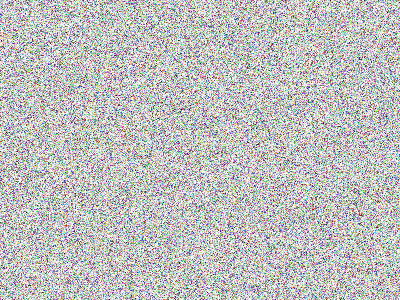

In [113]:
import IPython.display

def png_display(imagedata):
    return IPython.display.display(IPython.display.Image(data=png_image(imagedata)))

def png_save(filename, imagedata):
    with open(filename, "wb") as file:
        file.write(png_image(imagedata))   # a real PNG file that you can view with other programs

png_display(imagedata)

(You may be itching to tell me that Matplotlib's `imshow` does that, but the DIY solution will pay off in pedagogy.)

The part we skipped over was how to construct the image itself. We saw that it was an array with shape `(height, 4 * width + 1)` and the first byte of each row ("scanline") was zero. Here's a figure from the specification:

<center><img src="img/png-spec-scanline.png" width="60%"></center>

After the "filter type" (zero is simplest), they're alternating red, green, blue, "alpha" (transparency) bytes. If, for instance, we want to make the image all red, we'd set the red bytes and the alpha bytes to maximum (255), the others to zero. Use slices!

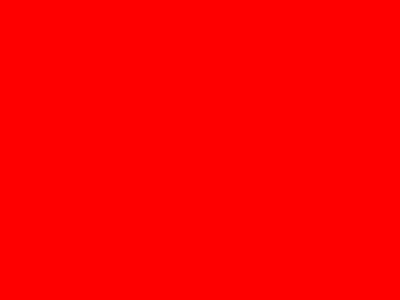

In [114]:
imagedata = numpy.zeros((height, 4 * width + 1), dtype="u1")
imagedata[:, 1::4] = 255     # max out red bytes
imagedata[:, 4::4] = 255     # max out alpha bytes
png_display(imagedata)

**Exercise:** Make a gradient from black to red using `linspace`:

In [ ]:
numpy.linspace(0, 255, 20, dtype="u1")

In [ ]:
imagedata = numpy.zeros((height, 4 * width + 1), dtype="u1")
imagedata[:, 1::4] = numpy.linspace(0, 255, width, dtype="u1")
imagedata[:, 4::4] = 255
png_display(imagedata)

**Harder exercise:** Now use multiplication by a `linspace` to make the gradient peak in the bottom-right corner.

In [ ]:
imagedata[:, 1::4] = imagedata[:, 1::4] * numpy.linspace(0, 1, height).reshape(height, 1)
png_display(imagedata)

For flair, let's put a streak of blue through it.

In [ ]:
imagedata[:, 3::4] = numpy.linspace(255, 0, width, dtype="u1")
png_display(imagedata)

We can chop up sections and move them around.

In [ ]:
imagedata[100:250, 601:681] = imagedata[100:250, 1201:1281]
png_display(imagedata)

And `roll` sections, like we did with the Rubik's square.

In [ ]:
imagedata[:, 801:881] = numpy.roll(imagedata[:, 801:881], 100, axis=0)
png_display(imagedata)

In [ ]:
imagedata[230:250, 1:] = numpy.roll(imagedata[230:250, 1:], 400, axis=1)
png_display(imagedata)

I'd like to draw your attention to that `axis` parameter. When we applied `roll` to the 2D array, we could tell it which dimension to roll. This is a general feature of Numpy:

   * `axis=0` means apply it to the first axis (the first dimension you'd slice in square brackets)
   * `axis=1` means apply it to the second
   * and so on.

Numpy arrays are truly N-dimensional objects. Nowadays, they'd be called "tensors" to sound cool.

Speaking of tensors, Numpy has a linear algebra module (usually compiles to BLAS/LAPACK, but can be ATLAS or MKL).

In [ ]:
matrix = numpy.array([[1.1, 2.2], [3.3, 4.4]])
matrix

In [ ]:
matrix.T    # shortcut for .transpose()

In [ ]:
numpy.linalg.inv(matrix)

In [ ]:
numpy.eye(2)   # identity or "I" (get it?)

In [ ]:
matrix @ matrix   # "at" sign means matrix multiplication in Python 3.5 and above

In [ ]:
numpy.matmul(matrix, matrix)   # if you're still living in Python 2.7

In [ ]:
numpy.linalg.matrix_power(matrix, 2)

In [ ]:
for eigenvector, eigenvalue in zip(numpy.linalg.eig(matrix), numpy.linalg.eigvals(matrix)):
    print("")
    print(eigenvector)
    print(eigenvalue)

In [ ]:
numpy.linalg.solve(matrix, eigenvector)

And many others. See the documentation.

Numpy has some basic statistics functions as well.

In [ ]:
a = numpy.random.normal(100, 5, 10000)
b = numpy.random.normal(0, 2, 10000) + a

In [ ]:
numpy.min(a), numpy.max(a)      # use nanmin, nanmax to ignore NaN

In [ ]:
numpy.mean(a)

In [ ]:
numpy.median(a)

In [ ]:
numpy.std(a)

In [ ]:
numpy.corrcoef(a, b)

In [ ]:
numpy.histogram(a, bins=10, range=(75, 125))    # counts in each bin, bin edges

**Useful odds and ends:** In my very first example, I used `where` as an if-then-else:

In [ ]:
            # condition                # if true                                    # if false
numpy.where(numpy.isnan(temperatures), 0.5 * (min_temperatures + max_temperatures), temperatures)

It can also be used to find the indexes of an array where the condition is non-zero.

In [ ]:
numpy.where(numpy.isnan(temperatures))

These indexes can then be used as a slice, much like the output of `argsort`, `argwhere`, etc. The reason it's a 1-tuple (notice the comma at the end?) is because it would give you N arrays for an N dimensional index.

In [ ]:
numpy.where(imagedata > 250)

In [ ]:
imagedata[numpy.where(imagedata > 250)]

**Here's another goodie:** sometimes you want a discrete lookup table. If the table has size `m` and the data you need to look up has size `n`, a naive search would take `O(n*m)` time. But if the lookup table is sorted, it only has to be `O(n*log(m))`.

In [ ]:
independent_variable = numpy.array([1.1, 1000.0, 2013.0216, 2099.99, 9999.9, 1e12, 2e55])   # size m
dependent_variable = numpy.array([1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7])                       # size m

dataset = numpy.exp(numpy.random.normal(0, 3, 100000)**2)                                   # size n
dataset

In [ ]:
indexes = numpy.searchsorted(independent_variable, dataset, side="left")       # bisection search every element in dataset

indexes[indexes == len(independent_variable)] = len(independent_variable) - 1  # clamp outliers to the valid range

dependent_variable[indexes]

(This is a low-level implementation of a sparse matrix...)

**Another gem:** Cumulative sum.

In [ ]:
random_numbers = numpy.random.normal(0, 1, 1000)

In [ ]:
random_walk = numpy.cumsum(random_numbers)
random_walk

**Splitting, stacking, and concatenating:** Numpy arrays must be contiguous in memory. Sometimes you need to work on a chunk at a time and then combine results.

In [ ]:
a = numpy.arange(103)

In [ ]:
abits = numpy.array_split(a, 10)
abits

In [ ]:
numpy.concatenate(abits)

In [ ]:
b = numpy.arange(100)
bbits = numpy.split(b, 10)    # must be exactly the same size
bbits

In [ ]:
numpy.vstack(bbits)    # hstack, vstack, dstack...

**Universal functions:** We've been using "universal functions" or "ufuncs" all along now: they're functions of n numbers → 1 number for small n, such as addition, trigonometry, exponentiation...

In [ ]:
a = numpy.arange(10) * 1.1

In [ ]:
a + a

In [ ]:
numpy.add(a, a)    # same thing

In [ ]:
numpy.sin(a)

In [ ]:
numpy.exp(a)

In [ ]:
type(numpy.add), type(numpy.sin), type(numpy.exp)

This function type constitutes a special protocol: some third-party libraries like SciPy define many more functions in this form and other third-party libraries override them with special powers.

Numpy ufuncs standardize fast computation just as Numpy arrays standardize views of bytes in memory.

They also have several "hidden" features:

In [ ]:
[x for x in dir(numpy.add) if not x.startswith("_")]

In [ ]:
a = numpy.array([1, 2, 3, 4, 5])
numpy.add.reduce(a)

In [ ]:
numpy.sum(a)

Okay, same result, but the `ufunc.reduce` gives you a reducer for any two-argument operation:

In [ ]:
numpy.multiply.reduce(a)

In [ ]:
numpy.bitwise_or.reduce(a)

Add (or whatever) irregularly sized subsequences of an array with `ufunc.reduceat`.

In [ ]:
a = numpy.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
i = numpy.array([0, 3, 5, 6, 9])
numpy.add.reduceat(a, i)

In [ ]:
(1 + 2), (3 + 4), (5), (6 + 7 + 8), (9)

Outer products (or sums or whatever) with `ufunc.outer`.

In [ ]:
a = numpy.arange(10)
b = numpy.arange(10) * 0.1

In [ ]:
numpy.add.outer(a, b)

`ufunc.at` is like assignment with fancy indexing, except that repeated values are accumulated.

In [ ]:
random_integers = numpy.random.randint(0, 10, 15)
random_integers

In [ ]:
not_a_histogram = numpy.zeros(10, dtype=numpy.int64)
not_a_histogram[random_integers] += 1
not_a_histogram

In [ ]:
yes_a_histogram = numpy.zeros(10, dtype=numpy.int64)
numpy.add.at(yes_a_histogram, random_integers, 1)
yes_a_histogram

**Saving your work:** Numpy has a file format; actually just raw data with `dtype/shape` interpretations in ZIP files.

In [ ]:
numpy.savez("output.npz", one=a, two=imagedata)

In [ ]:
file = numpy.load("output.npz")

In [ ]:
file["one"]

In [ ]:
file["two"]

This format is simple but pretty efficient. (Use `numpy.savez_compressed` to also compress the arrays.)

For more options and interoperability, use the h5py or pytables libraries to save/load HDF5.

This is a good place to stop because we'll cover other libraries in the Numpy ecosystem after lunch.